In [1]:
import os,sys,inspect
import networkx as nx
import matplotlib.pyplot as plt 
from pprint import pprint
import json
from nlp.processors import TextAnalyzer

In [2]:
def _clean_recoursive(branch):
    if isinstance(branch, dict):
        for key, val in branch.items():
            branch[key] = _clean_recoursive(val)
    elif isinstance(branch, (list, tuple)):
        result = []
        for elem in branch:
            elem = _clean_recoursive(elem)
            result.append(elem)
        return result

    else:
        return branch.replace('_', ' ')

    return branch


def construct_graph_description(topics):
    """
    Constructs igraph graph description (vertices+edges+labels)

    :param topics: <dict> (created by TextAnalyzer.topics)
    :retunr: <dict> igraph graph definition
    """
    subtopics = topics
    vertices = dict()
    vertices_list = []
    vertices_list_distance = []
    vertex_number = 0
    # we are going through all the keys of topics dictionary and add their subtopics to list
    for key in subtopics.keys():
        subtopic_list = subtopics[key]["subtopics"]
        if key not in vertices_list:
            vertices[key] = vertex_number
            vertices_list.append(key)
            vertices_list_distance.append(subtopics[key]["distance"])
            vertex_number += 1
        # add all subtopics
        subtopic_list = subtopics[key]["subtopics"]
        for i in range(0, len(subtopic_list)):
            # we have to check if the subtopic isn"t already in the list
            #     - can be there from parsing of previous nodes
            if subtopic_list[i][0] not in vertices_list:
                vertices[subtopic_list[i][0]] = vertex_number
                vertices_list.append(subtopic_list[i][0])
                # if the subtopic is the last leaf in the graph
                #     it won"t be a key in the topics dictionary
                try:
                    vertices_list_distance.append(subtopics[subtopic_list[i][0]]["distance"])
                except KeyError:
                    vertices_list_distance.append(subtopics[key]["distance"]+1)
                vertex_number += 1
    graph_definition = {
        'vertices': vertices_list,
        'distance': vertices_list_distance,
        'edges': [],
        'edge_distance': []
    }
    # add edges
    for key in subtopics.keys():
        subtopic_list = subtopics[key]["subtopics"]
        for i in range(0, len(subtopic_list)):
            # checking if the edge exists - get_eid throws an exception when
            #    there is no edge betweed the two vertices
            if ((vertices[key], vertices[subtopic_list[i][0]]) not in graph_definition["edges"]) and ((vertices[subtopic_list[i][0]], vertices[key]) not in graph_definition["edges"]):
                graph_definition["edges"].append((vertices[key], vertices[subtopic_list[i][0]]))
                graph_definition["edge_distance"].append("{:.2f}".format(subtopic_list[i][1]))
    # return the iGraph graph definition
    return graph_definition

In [3]:
def draw_graph(subtopics):
    
    graph_desc = construct_graph_description(subtopics)
    # construct networkx graph

    edges = []
    for (e1,e2) in graph_desc['edges']:
        edges.append((graph_desc['vertices'][e1], graph_desc['vertices'][e2]))

    edge_labels = {}
    for e_tup,e_label in zip(edges,graph_desc['edge_distance']):
        edge_labels[e_tup]=e_label

    G=nx.Graph()
    G.add_nodes_from(graph_desc['vertices'])
    G.add_edges_from(edges)
    plt.figure(figsize=(12,12), dpi=100)   
    #pos = nx.kamada_kawai_layout(G)
    pos = nx.spring_layout(G)
    nx.draw(G,pos)
    color_dict = {0: "blue", 1: "red", 2: "yellow", 3: "green", 4: "pink"}
    nx.draw_networkx_nodes(G,pos,node_size = 500, node_color=[color_dict[dist] for dist in graph_desc['distance']])
    nx.draw_networkx_labels(G,pos)
    # uncomment to see the edge labels - similarities
    #nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)

    #plt.savefig("networkx_graph.png") # save as png
    plt.show() 

In [4]:
# load some text
with open('/home/dzon/kajo/sk-texts/polnohospodarstvo.txt', encoding="utf-8", mode="r") as fp:
   text = fp.read() 

In [5]:
ta = TextAnalyzer(lang='sk')

Subtopics graph with all subtopics from the model:


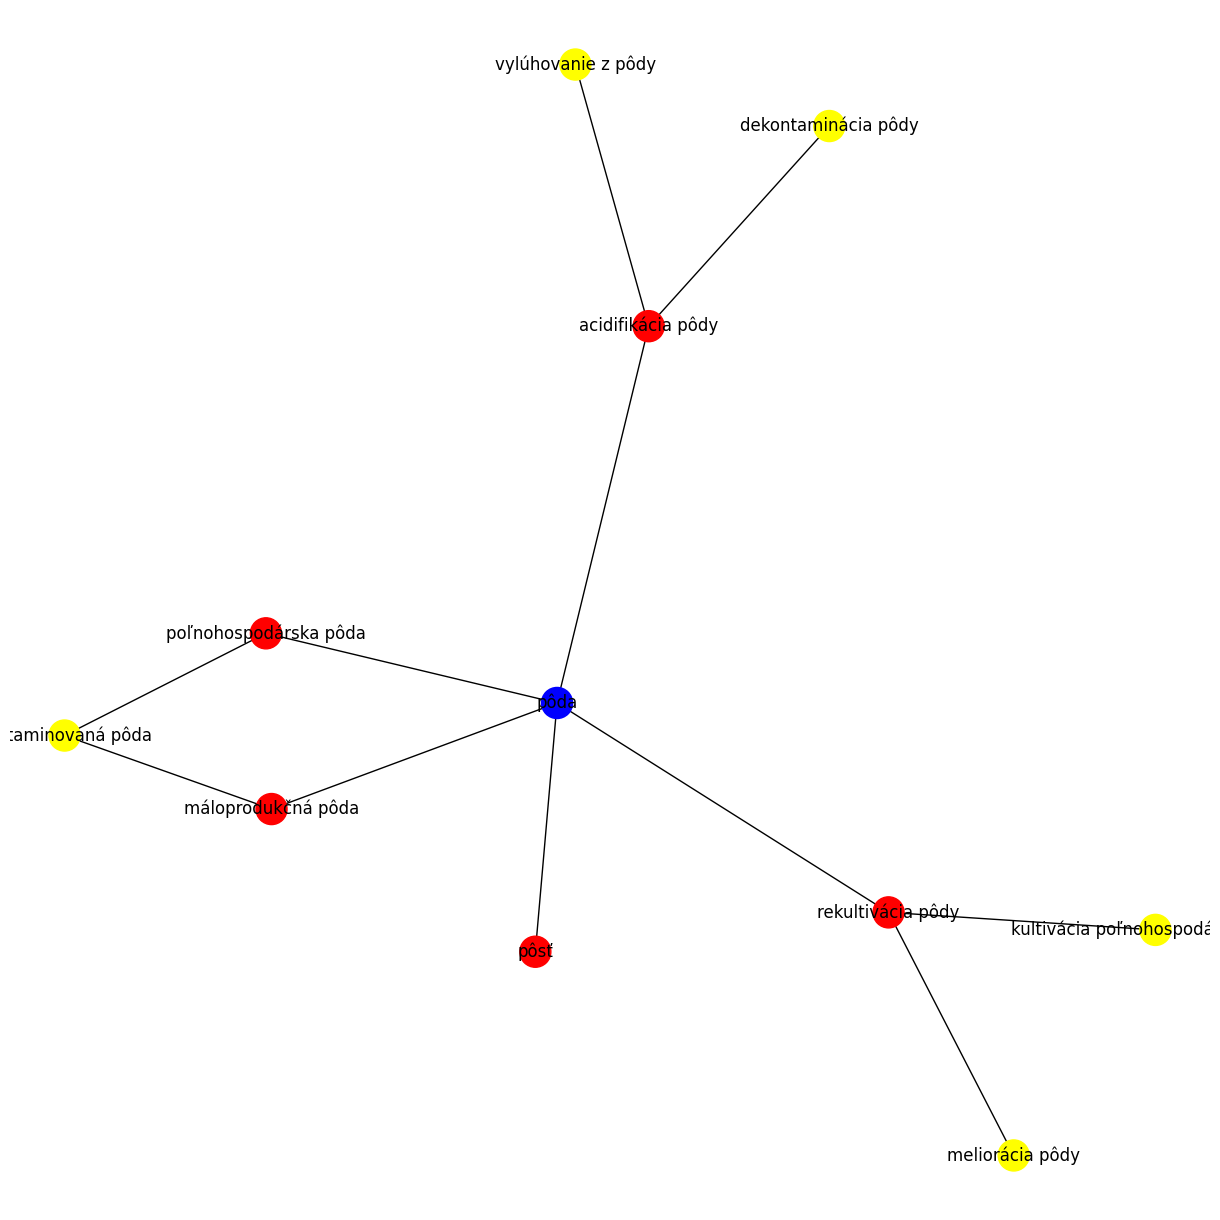

['horská oblasť', 'prírodná oblasť', 'obytná oblasť', 'rekreačná oblasť', 'arídna oblasť', 'citlivá oblasť', 'zastavaná oblasť', 'nezastavaná oblasť', 'riziková oblasť', 'vidiecke prostredie']
Filtered subtopics graph with text-relevant topics:


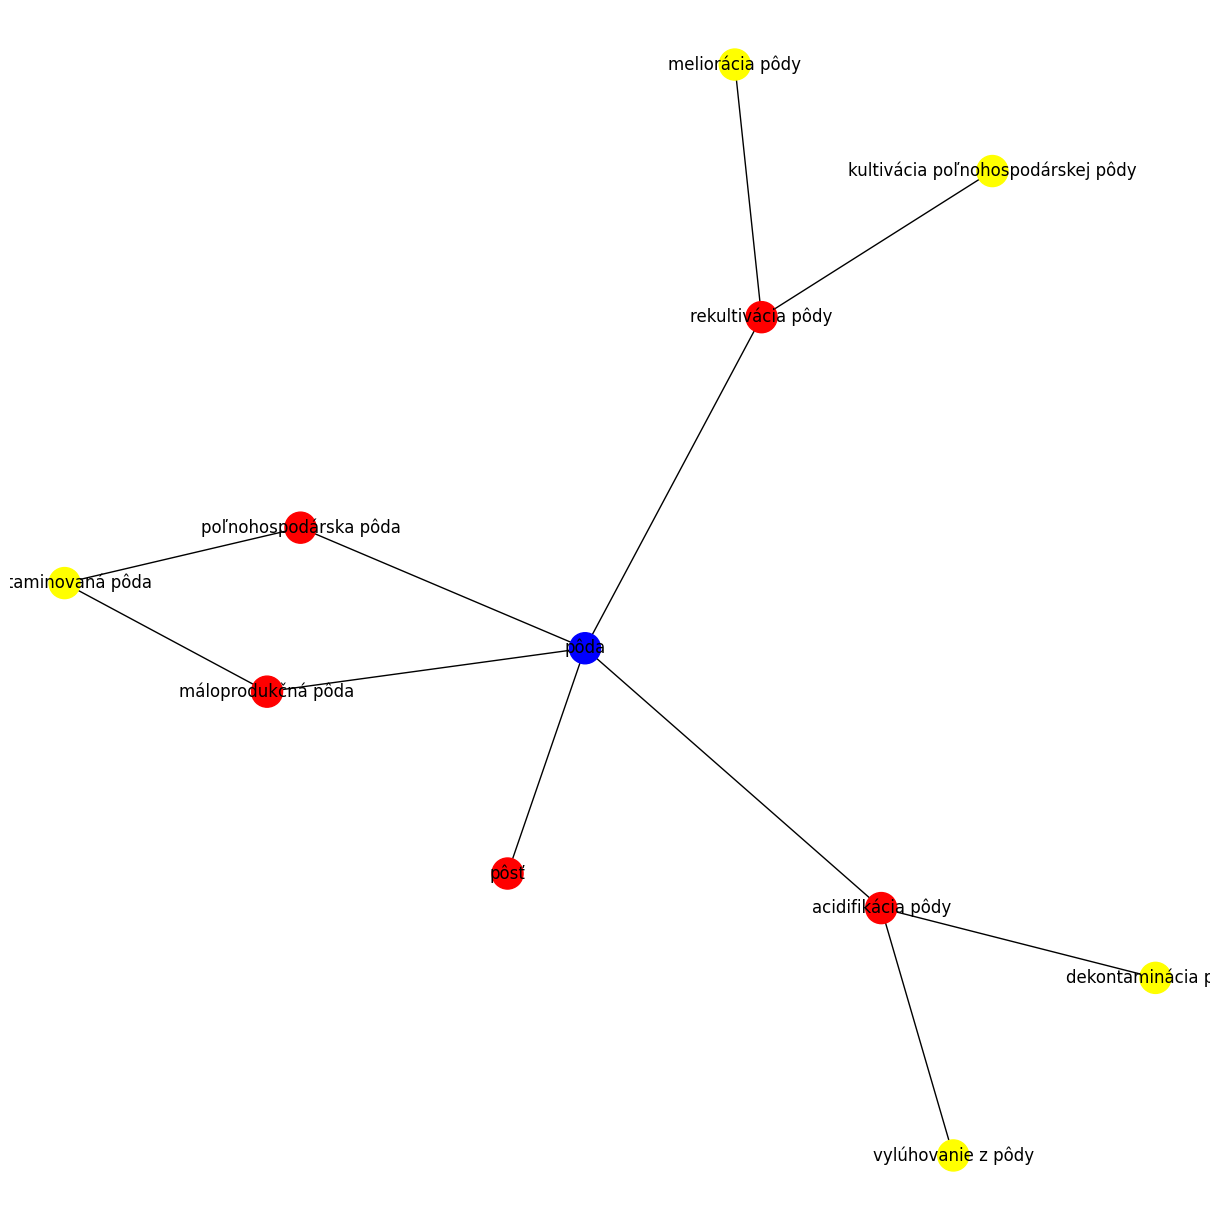

In [20]:
root_topic = 'pôda'
#subtopics_from_root_topic = ta.get_subtopics(root_topic, threshold=0.6, topn=5)
subtopics_from_root_topic = ta.get_subtopics(root_topic, threshold=0.6, topn=5)
print("Subtopics graph with all subtopics from the model:")
draw_graph(subtopics_from_root_topic)

print(ta.topics(text))
subtopics_filtered = ta.get_subtopics_from_text(text, root_topic, min_sim_topic = 0.8)
print("Filtered subtopics graph with text-relevant topics:")
draw_graph(subtopics_filtered)

Subtopics graph with all subtopics from the model:


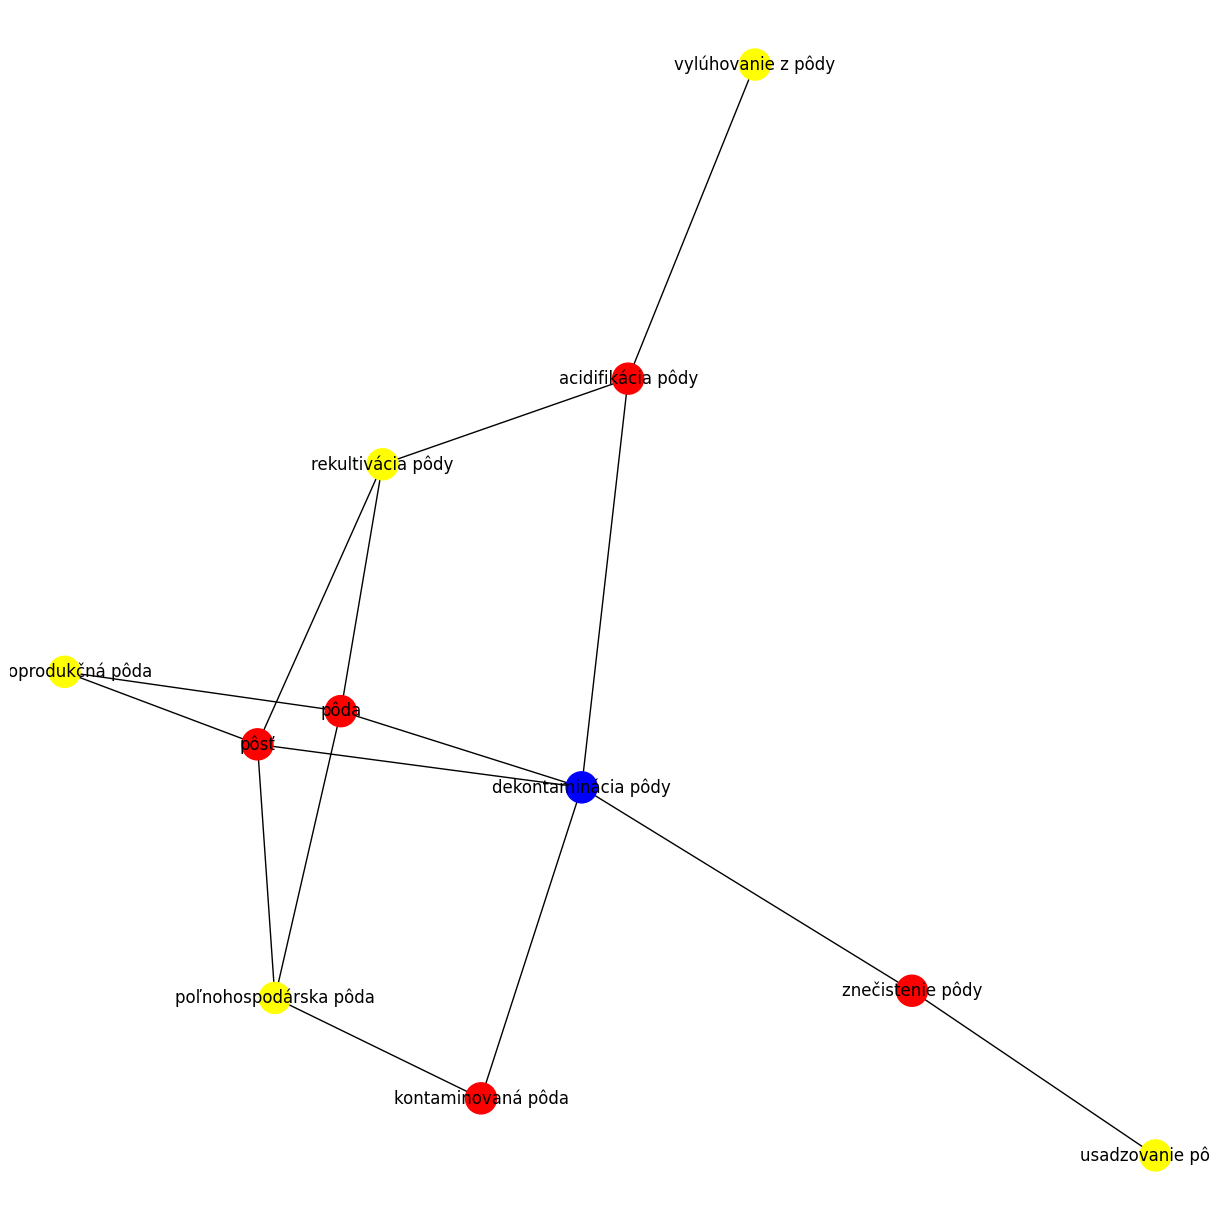

{'dekontaminácia pôdy': {'distance': 0,
  'subtopics': [('kontaminovaná pôda', 0.9562970995903015),
   ('acidifikácia pôdy', 0.9487296938896179),
   ('pôda', 0.9439861178398132),
   ('pôsť', 0.9439861178398132),
   ('znečistenie pôdy', 0.9371675848960876)]},
 'kontaminovaná pôda': {'distance': 1,
  'subtopics': [('poľnohospodárska pôda', 0.9402103424072266)]},
 'acidifikácia pôdy': {'distance': 1,
  'subtopics': [('rekultivácia pôdy', 0.9499444961547852),
   ('vylúhovanie z pôdy', 0.9473940134048462)]},
 'pôda': {'distance': 1,
  'subtopics': [('poľnohospodárska pôda', 0.9717153310775757),
   ('máloprodukčná pôda', 0.9557732343673706),
   ('rekultivácia pôdy', 0.9539445042610168)]},
 'pôsť': {'distance': 1,
  'subtopics': [('poľnohospodárska pôda', 0.9717153310775757),
   ('máloprodukčná pôda', 0.9557732343673706),
   ('rekultivácia pôdy', 0.9539445042610168)]},
 'znečistenie pôdy': {'distance': 1,
  'subtopics': [('usadzovanie pôdy', 0.923734188079834)]}}

In [7]:
root_topic = 'dekontaminácia_pôda'
ta = TextAnalyzer(lang='sk')

subtopics_from_root_topic = ta.subtopics(topics=[root_topic], threshold=0.6, topn=5)
print("Subtopics graph with all subtopics from the model:")
draw_graph(subtopics_from_root_topic)

subtopics_from_root_topic


['krajina',
 'ekomarketing',
 'politika',
 'región',
 'štát',
 'druh',
 'priemysel',
 'socioekonómia',
 'poľnohospodárstvo',
 'mesto']
{'krajina': 0.2075342558193849}

Original subtopics graph:


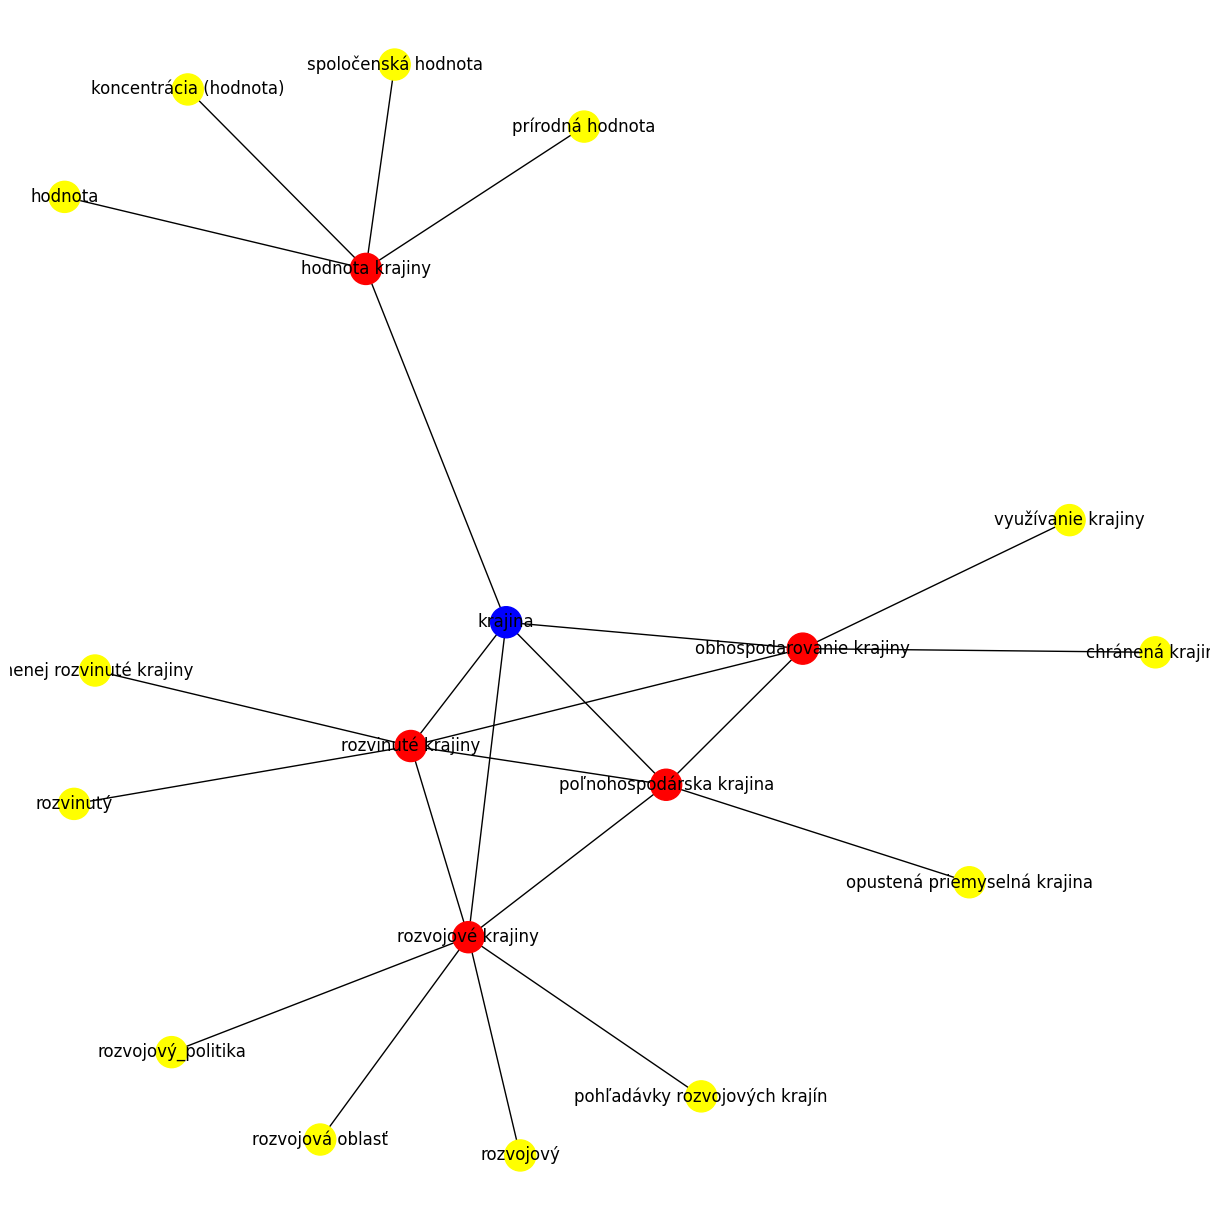

['krajina'] <class 'list'> 1

Filtered tree subtopics graph:


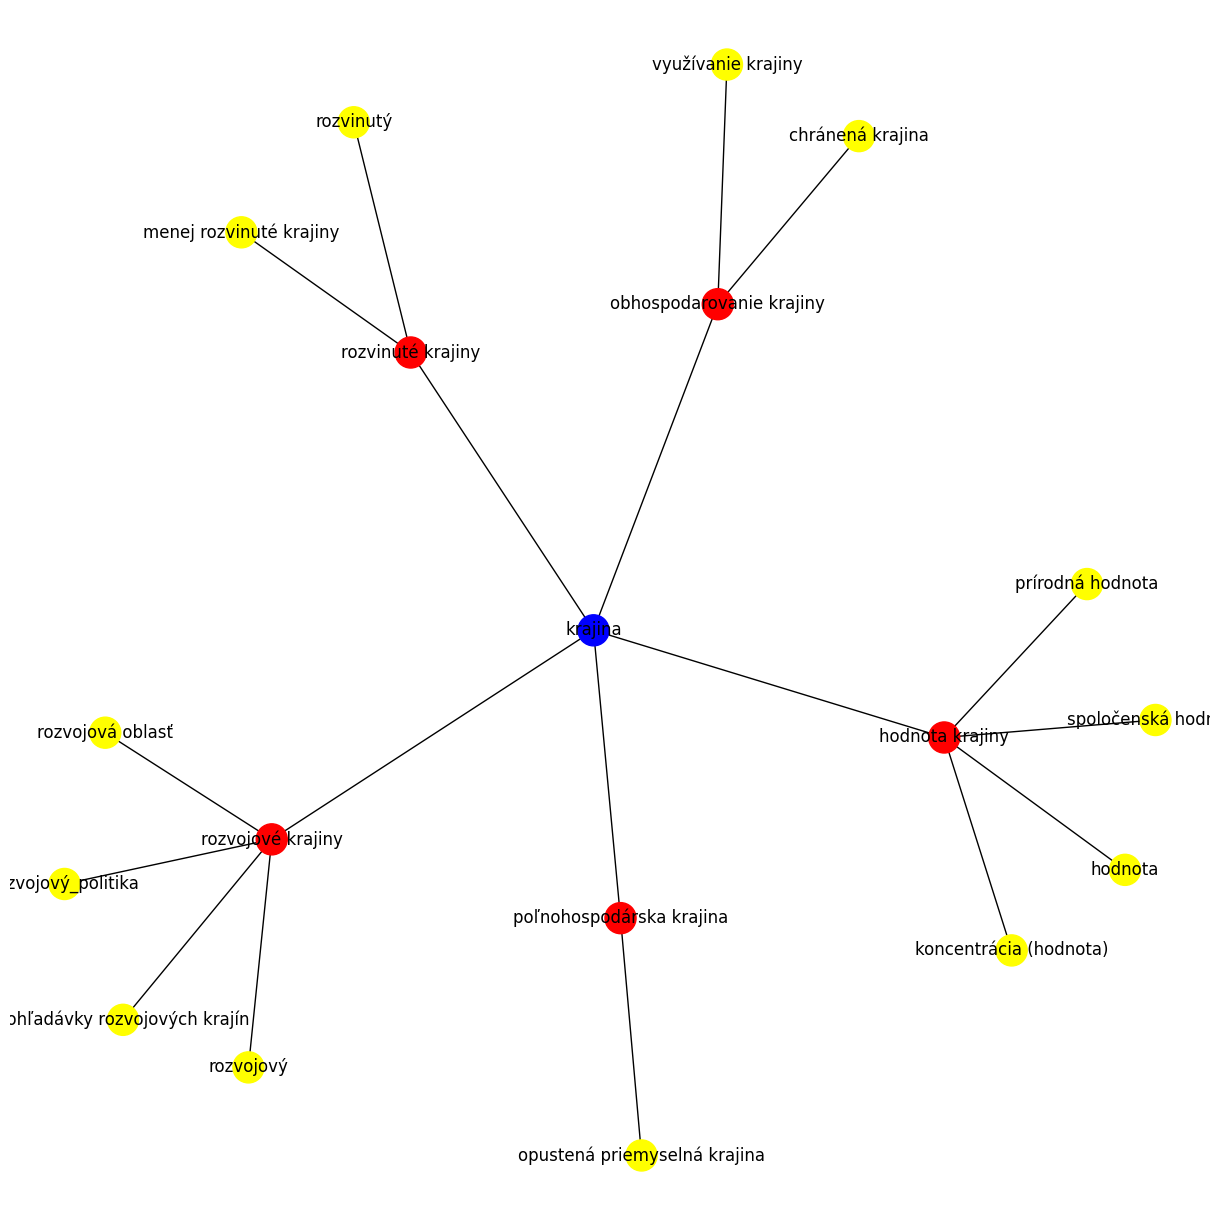

In [8]:
#topic_list = ['rural_areas', 'small_city', 'remote_areas']
topic_list = ['rural_areas']

# keyword extraction from text
keywords = ta.get_keywords(text)
#print()
#pprint(keywords)

# topic extraction from text
topics = ta.get_topics(text)
print()
pprint(topics)
extracted_topics = ta.get_topics(text, max_topics=1, keywords=10, include_metrics=True)
#print()
pprint(extracted_topics)

#get subtopics in original form with cross connections
extracted_topics_list = list(extracted_topics.keys())[0]
extracted_topics_list = extracted_topics_list.replace(" ","_")
subtopics = ta.get_subtopics(extracted_topics_list, depth=2, threshold=0.6, topn=5, clean_tree=False)
print()
#pprint(subtopics)
print("Original subtopics graph:")
draw_graph(subtopics)

tmp_list = list(extracted_topics.keys())
print(tmp_list, type(tmp_list), len(tmp_list))

subtopics = ta.subtopics(topics = tmp_list, depth=2, threshold=0.6, topn=5)
print()
#pprint(subtopics)
print("Filtered tree subtopics graph:")
draw_graph(subtopics)